# 06. 파이썬을 이용한 CNN for Text (Using Gensim + Keras)

* 싸이그래머 / 어바웃 파이썬
* 김무성

# 차례
* Word2Vec (Gensim) + Deep Learning (Keras) 간단 예제 : 코사도 유사도  
* 1D CNN for Text (Gensim + Keras)
* 2D CNN for Text (Gensim + Keras)

# Word2Vec (Gensim) + Deep Learning (Keras) 간단 예제 : 코사도 유사도 

In [1]:
from gensim.models import word2vec

In [2]:
sentences = [
    ['human', 'interface', 'computer'],
    ['survey', 'user', 'computer', 'system', 'response', 'time'],
    ['eps', 'user', 'interface', 'system'],
    ['system', 'human', 'system', 'eps'],
    ['user', 'response', 'time'],
    ['trees'],
    ['graph', 'trees'],
    ['graph', 'minors', 'trees'],
    ['graph', 'minors', 'survey']
]

In [3]:
model = word2vec.Word2Vec(sentences, size=100, min_count=1, hs=1)

In [4]:
import numpy as np
from keras.engine import Input
from keras.models import Model
from keras.layers.merge import dot

Using TensorFlow backend.


In [5]:
wv = model.wv
embedding_layer = wv.get_keras_embedding()

In [6]:
input_a = Input(shape=(1,), dtype='int32', name='input_a')
input_b = Input(shape=(1,), dtype='int32', name='input_b')
embedding_a = embedding_layer(input_a)
embedding_b = embedding_layer(input_b)
similarity = dot([embedding_a, embedding_b], axes=2, normalize=True)

keras_model = Model(input=[input_a, input_b], output=similarity)
keras_model.compile(optimizer='sgd', loss='mse')

Instructions for updating:
dim is deprecated, use axis instead


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("do..., inputs=[<tf.Tenso...)`


In [7]:
word_a = 'graph'
word_b = 'trees'
# output is the cosine distance between the two words (as a similarity measure)
output = keras_model.predict([np.asarray([model.wv.vocab[word_a].index]), np.asarray([model.wv.vocab[word_b].index])])

print(output)

[[[ 0.1080837]]]


--------------------------

# 1D CNN for Text (Gensim + Keras) 
* Data 준비
* 딥러닝 모델에 입력가능한 포맷으로 변환
* Keras에서 사용할 embedding layer 생성
* CNN 모델 생성 및 학습
* 학습된 모델로 새로운 문장

#### 참고
* [2] Using wrappers for Gensim models for working with Keras - https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/keras_wrapper.ipynb

<img src="https://qph.ec.quoracdn.net/main-qimg-523434af0d21bb0b59454aa9563cc90b-c" width=600 />

## Data 준비 (영어 - 20newsgroups)

#### 필요한 라이브러리들

In [8]:
import os
import sys
import keras
import numpy as np

from gensim.models import word2vec

from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D

from sklearn.datasets import fetch_20newsgroups

#### 데이터 준비 결과는 아래 세 리스트에 담긴다.

In [9]:
texts = []  # list of text samples
texts_w2v = []  # used to train the word embeddings
labels = []  # list of label ids

#### 20뉴스그룹 데이터의 일부분(카테고리 3가지 정도만)을 가져온다

In [10]:
#using 3 categories for training the classifier
data = fetch_20newsgroups(subset='train', categories=['alt.atheism', 'comp.graphics', 'sci.space'])

In [11]:
dir(data)

['DESCR', 'data', 'description', 'filenames', 'target', 'target_names']

In [12]:
len(data)

6

In [13]:
data.description

'the 20 newsgroups by date dataset'

In [14]:
len(data.data)

1657

In [15]:
len(data.target)

1657

In [16]:
data.target

array([2, 1, 0, ..., 2, 2, 2])

In [17]:
data.target_names

['alt.atheism', 'comp.graphics', 'sci.space']

#### 변환 과정을 한줄한줄 따져보자

In [18]:
for index in range(len(data)):
    print("index:", index)
    label_id = data.target[index]
    print("label_id:",label_id)
    #file_data = data.data[index]
    #print(file_data)
    #i = file_data.find('\n\n')  # skip header
    #if i > 0:
    #    file_data = file_data[i:]
    #try:
    #    curr_str = str(file_data)
    #    sentence_list = curr_str.split('\n')
    #    for sentence in sentence_list:
    #        sentence = (sentence.strip()).lower()
    #        texts.append(sentence)
    #        texts_w2v.append(sentence.split(' '))
    #        labels.append(label_id)
    #except:
    #    None

index: 0
label_id: 2
index: 1
label_id: 1
index: 2
label_id: 0
index: 3
label_id: 1
index: 4
label_id: 2
index: 5
label_id: 2


In [19]:
for index in range(len(data)):
    print("index:", index)
    label_id = data.target[index]
    print("label_id:",label_id)
    file_data = data.data[index]
    print("file_data:\n",file_data)
    #i = file_data.find('\n\n')  # skip header
    #if i > 0:
    #    file_data = file_data[i:]
    #try:
    #    curr_str = str(file_data)
    #    sentence_list = curr_str.split('\n')
    #    for sentence in sentence_list:
    #        sentence = (sentence.strip()).lower()
    #        texts.append(sentence)
    #        texts_w2v.append(sentence.split(' '))
    #        labels.append(label_id)
    #except:
    #    None

index: 0
label_id: 2
file_data:
 From: degroff@netcom.com (21012d)
Subject: Re: Venus Lander for Venus Conditions.
Organization: Netcom Online Communications Services (408-241-9760 login: guest)
Lines: 8


  I doubt there are good prospects for  a self armoring system
for venus surface conditions (several hundred degrees, very high
pressure of CO2, possibly sulfuric and nitric acids or oxides
but it is a notion to consider for outer planets rs where you might
pick up ices under less extream upper atmosphere conditions buying
deeper penetration.  A nice creative idea, unlikly but worthy of
thinking about.

index: 1
label_id: 1
file_data:
 From: ab@nova.cc.purdue.edu (Allen B)
Subject: Re: TIFF: philosophical significance of 42
Organization: Purdue University
Lines: 39

In article <prestonm.735400848@cs.man.ac.uk> prestonm@cs.man.ac.uk (Martin  
Preston) writes:
> Why not use the PD C library for reading/writing TIFF files? It took me a
> good 20 minutes to start using them in your own a

#### 첫번째 데이터만 가져와서 처리 과정을 차근차근 살펴보자

In [20]:
for index in range(1) : #len(data)):
    print("index:", index)
    label_id = data.target[index]
    print("label_id:",label_id)
    file_data = data.data[index]
    print("file_data:\n",file_data)
    #i = file_data.find('\n\n')  # skip header
    #if i > 0:
    #    file_data = file_data[i:]
    #try:
    #    curr_str = str(file_data)
    #    sentence_list = curr_str.split('\n')
    #    for sentence in sentence_list:
    #        sentence = (sentence.strip()).lower()
    #        texts.append(sentence)
    #        texts_w2v.append(sentence.split(' '))
    #        labels.append(label_id)
    #except:
    #    None

index: 0
label_id: 2
file_data:
 From: degroff@netcom.com (21012d)
Subject: Re: Venus Lander for Venus Conditions.
Organization: Netcom Online Communications Services (408-241-9760 login: guest)
Lines: 8


  I doubt there are good prospects for  a self armoring system
for venus surface conditions (several hundred degrees, very high
pressure of CO2, possibly sulfuric and nitric acids or oxides
but it is a notion to consider for outer planets rs where you might
pick up ices under less extream upper atmosphere conditions buying
deeper penetration.  A nice creative idea, unlikly but worthy of
thinking about.



In [21]:
for index in range(1) : #len(data)):
    print("index:", index)
    label_id = data.target[index]
    print("label_id:",label_id)
    file_data = data.data[index]
    print("file_data:\n",file_data)
    i = file_data.find('\n\n')  # skip header
    print("i:", i)
    #if i > 0:
    #    file_data = file_data[i:]
    #try:
    #    curr_str = str(file_data)
    #    sentence_list = curr_str.split('\n')
    #    for sentence in sentence_list:
    #        sentence = (sentence.strip()).lower()
    #        texts.append(sentence)
    #        texts_w2v.append(sentence.split(' '))
    #        labels.append(label_id)
    #except:
    #    None

index: 0
label_id: 2
file_data:
 From: degroff@netcom.com (21012d)
Subject: Re: Venus Lander for Venus Conditions.
Organization: Netcom Online Communications Services (408-241-9760 login: guest)
Lines: 8


  I doubt there are good prospects for  a self armoring system
for venus surface conditions (several hundred degrees, very high
pressure of CO2, possibly sulfuric and nitric acids or oxides
but it is a notion to consider for outer planets rs where you might
pick up ices under less extream upper atmosphere conditions buying
deeper penetration.  A nice creative idea, unlikly but worthy of
thinking about.

i: 170


In [22]:
for index in range(1) : #len(data)):
    print("index:", index)
    label_id = data.target[index]
    print("label_id:",label_id)
    file_data = data.data[index]
    print("file_data:\n",file_data)
    i = file_data.find('\n\n')  # skip header
    print("i:", i)
    if i > 0:
        file_data = file_data[i:]
        print("file_data(skip_heaer):", file_data)
    #try:
    #    curr_str = str(file_data)
    #    sentence_list = curr_str.split('\n')
    #    for sentence in sentence_list:
    #        sentence = (sentence.strip()).lower()
    #        texts.append(sentence)
    #        texts_w2v.append(sentence.split(' '))
    #        labels.append(label_id)
    #except:
    #    None

index: 0
label_id: 2
file_data:
 From: degroff@netcom.com (21012d)
Subject: Re: Venus Lander for Venus Conditions.
Organization: Netcom Online Communications Services (408-241-9760 login: guest)
Lines: 8


  I doubt there are good prospects for  a self armoring system
for venus surface conditions (several hundred degrees, very high
pressure of CO2, possibly sulfuric and nitric acids or oxides
but it is a notion to consider for outer planets rs where you might
pick up ices under less extream upper atmosphere conditions buying
deeper penetration.  A nice creative idea, unlikly but worthy of
thinking about.

i: 170
file_data(skip_heaer): 


  I doubt there are good prospects for  a self armoring system
for venus surface conditions (several hundred degrees, very high
pressure of CO2, possibly sulfuric and nitric acids or oxides
but it is a notion to consider for outer planets rs where you might
pick up ices under less extream upper atmosphere conditions buying
deeper penetration.  A nice c

In [23]:
for index in range(1) : #len(data)):
    #print("index:", index)
    label_id = data.target[index]
    #print("label_id:",label_id)
    file_data = data.data[index]
    #print("file_data:\n",file_data)
    i = file_data.find('\n\n')  # skip header
    #print("i:", i)
    if i > 0:
        file_data = file_data[i:]
        #print("file_data(skip_heaer):", file_data)
    try:
        curr_str = str(file_data)
        print("curr_str", curr_str)
    #    sentence_list = curr_str.split('\n')
    #    for sentence in sentence_list:
    #        sentence = (sentence.strip()).lower()
    #        texts.append(sentence)
    #        texts_w2v.append(sentence.split(' '))
    #        labels.append(label_id)
    except:
        None

curr_str 


  I doubt there are good prospects for  a self armoring system
for venus surface conditions (several hundred degrees, very high
pressure of CO2, possibly sulfuric and nitric acids or oxides
but it is a notion to consider for outer planets rs where you might
pick up ices under less extream upper atmosphere conditions buying
deeper penetration.  A nice creative idea, unlikly but worthy of
thinking about.



In [24]:
for index in range(1) : #len(data)):
    #print("index:", index)
    label_id = data.target[index]
    #print("label_id:",label_id)
    file_data = data.data[index]
    #print("file_data:\n",file_data)
    i = file_data.find('\n\n')  # skip header
    #print("i:", i)
    if i > 0:
        file_data = file_data[i:]
        #print("file_data(skip_heaer):", file_data)
    try:
        curr_str = str(file_data)
        print("curr_str", curr_str)
        sentence_list = curr_str.split('\n')
        print("sentence_list:\n", sentence_list)
    #    for sentence in sentence_list:
    #        sentence = (sentence.strip()).lower()
    #        texts.append(sentence)
    #        texts_w2v.append(sentence.split(' '))
    #        labels.append(label_id)
    except:
        None

curr_str 


  I doubt there are good prospects for  a self armoring system
for venus surface conditions (several hundred degrees, very high
pressure of CO2, possibly sulfuric and nitric acids or oxides
but it is a notion to consider for outer planets rs where you might
pick up ices under less extream upper atmosphere conditions buying
deeper penetration.  A nice creative idea, unlikly but worthy of
thinking about.

sentence_list:
 ['', '', '', '  I doubt there are good prospects for  a self armoring system', 'for venus surface conditions (several hundred degrees, very high', 'pressure of CO2, possibly sulfuric and nitric acids or oxides', 'but it is a notion to consider for outer planets rs where you might', 'pick up ices under less extream upper atmosphere conditions buying', 'deeper penetration.  A nice creative idea, unlikly but worthy of', 'thinking about.', '']


In [25]:
for index in range(1) : #len(data)):
    #print("index:", index)
    label_id = data.target[index]
    #print("label_id:",label_id)
    file_data = data.data[index]
    #print("file_data:\n",file_data)
    i = file_data.find('\n\n')  # skip header
    #print("i:", i)
    if i > 0:
        file_data = file_data[i:]
        #print("file_data(skip_heaer):", file_data)
    try:
        curr_str = str(file_data)
        print("curr_str", curr_str)
        sentence_list = curr_str.split('\n')
        print("sentence_list:\n", sentence_list)
        for sentence in sentence_list:
            sentence = (sentence.strip()).lower()
            print("sentence:\n", sentence)
    #        texts.append(sentence)
    #        texts_w2v.append(sentence.split(' '))
    #        labels.append(label_id)
    except:
        None

curr_str 


  I doubt there are good prospects for  a self armoring system
for venus surface conditions (several hundred degrees, very high
pressure of CO2, possibly sulfuric and nitric acids or oxides
but it is a notion to consider for outer planets rs where you might
pick up ices under less extream upper atmosphere conditions buying
deeper penetration.  A nice creative idea, unlikly but worthy of
thinking about.

sentence_list:
 ['', '', '', '  I doubt there are good prospects for  a self armoring system', 'for venus surface conditions (several hundred degrees, very high', 'pressure of CO2, possibly sulfuric and nitric acids or oxides', 'but it is a notion to consider for outer planets rs where you might', 'pick up ices under less extream upper atmosphere conditions buying', 'deeper penetration.  A nice creative idea, unlikly but worthy of', 'thinking about.', '']
sentence:
 
sentence:
 
sentence:
 
sentence:
 i doubt there are good prospects for  a self armoring system
sentence:
 fo

In [26]:
texts = []  # list of text samples
texts_w2v = []  # used to train the word embeddings
labels = []  # list of label ids

for index in range(1) : #len(data)):
    #print("index:", index)
    label_id = data.target[index]
    #print("label_id:",label_id)
    file_data = data.data[index]
    #print("file_data:\n",file_data)
    i = file_data.find('\n\n')  # skip header
    #print("i:", i)
    if i > 0:
        file_data = file_data[i:]
        #print("file_data(skip_heaer):", file_data)
    try:
        curr_str = str(file_data)
        #print("curr_str", curr_str)
        sentence_list = curr_str.split('\n')
        #print("sentence_list:\n", sentence_list)
        for sentence in sentence_list:
            sentence = (sentence.strip()).lower()
            print("sentence:\n", sentence)
            texts.append(sentence)
    #        texts_w2v.append(sentence.split(' '))
    #        labels.append(label_id)
    except:
        None

print("texts:\n", texts)
print("texts_w2v:\n", texts_w2v)
print("labels:\n", labels)

sentence:
 
sentence:
 
sentence:
 
sentence:
 i doubt there are good prospects for  a self armoring system
sentence:
 for venus surface conditions (several hundred degrees, very high
sentence:
 pressure of co2, possibly sulfuric and nitric acids or oxides
sentence:
 but it is a notion to consider for outer planets rs where you might
sentence:
 pick up ices under less extream upper atmosphere conditions buying
sentence:
 deeper penetration.  a nice creative idea, unlikly but worthy of
sentence:
 thinking about.
sentence:
 
texts:
 ['', '', '', 'i doubt there are good prospects for  a self armoring system', 'for venus surface conditions (several hundred degrees, very high', 'pressure of co2, possibly sulfuric and nitric acids or oxides', 'but it is a notion to consider for outer planets rs where you might', 'pick up ices under less extream upper atmosphere conditions buying', 'deeper penetration.  a nice creative idea, unlikly but worthy of', 'thinking about.', '']
texts_w2v:
 []
labels

In [27]:
texts = []  # list of text samples
texts_w2v = []  # used to train the word embeddings
labels = []  # list of label ids

for index in range(1) : #len(data)):
    #print("index:", index)
    label_id = data.target[index]
    #print("label_id:",label_id)
    file_data = data.data[index]
    #print("file_data:\n",file_data)
    i = file_data.find('\n\n')  # skip header
    #print("i:", i)
    if i > 0:
        file_data = file_data[i:]
        #print("file_data(skip_heaer):", file_data)
    try:
        curr_str = str(file_data)
        #print("curr_str", curr_str)
        sentence_list = curr_str.split('\n')
        #print("sentence_list:\n", sentence_list)
        for sentence in sentence_list:
            sentence = (sentence.strip()).lower()
            #print("sentence:\n", sentence)
            texts.append(sentence)
            texts_w2v.append(sentence.split(' '))
    #        labels.append(label_id)
    except:
        None

print("texts:\n", texts)
print("texts_w2v:\n", texts_w2v)
print("labels:\n", labels)

texts:
 ['', '', '', 'i doubt there are good prospects for  a self armoring system', 'for venus surface conditions (several hundred degrees, very high', 'pressure of co2, possibly sulfuric and nitric acids or oxides', 'but it is a notion to consider for outer planets rs where you might', 'pick up ices under less extream upper atmosphere conditions buying', 'deeper penetration.  a nice creative idea, unlikly but worthy of', 'thinking about.', '']
texts_w2v:
 [[''], [''], [''], ['i', 'doubt', 'there', 'are', 'good', 'prospects', 'for', '', 'a', 'self', 'armoring', 'system'], ['for', 'venus', 'surface', 'conditions', '(several', 'hundred', 'degrees,', 'very', 'high'], ['pressure', 'of', 'co2,', 'possibly', 'sulfuric', 'and', 'nitric', 'acids', 'or', 'oxides'], ['but', 'it', 'is', 'a', 'notion', 'to', 'consider', 'for', 'outer', 'planets', 'rs', 'where', 'you', 'might'], ['pick', 'up', 'ices', 'under', 'less', 'extream', 'upper', 'atmosphere', 'conditions', 'buying'], ['deeper', 'penetrati

In [28]:
texts = []  # list of text samples
texts_w2v = []  # used to train the word embeddings
labels = []  # list of label ids

for index in range(1) : #len(data)):
    #print("index:", index)
    label_id = data.target[index]
    #print("label_id:",label_id)
    file_data = data.data[index]
    #print("file_data:\n",file_data)
    i = file_data.find('\n\n')  # skip header
    #print("i:", i)
    if i > 0:
        file_data = file_data[i:]
        #print("file_data(skip_heaer):", file_data)
    try:
        curr_str = str(file_data)
        #print("curr_str", curr_str)
        sentence_list = curr_str.split('\n')
        #print("sentence_list:\n", sentence_list)
        for sentence in sentence_list:
            sentence = (sentence.strip()).lower()
            #print("sentence:\n", sentence)
            texts.append(sentence)
            texts_w2v.append(sentence.split(' '))
            labels.append(label_id)
    except:
        None

print("texts:\n", texts)
print("texts_w2v:\n", texts_w2v)
print("labels:\n", labels)

texts:
 ['', '', '', 'i doubt there are good prospects for  a self armoring system', 'for venus surface conditions (several hundred degrees, very high', 'pressure of co2, possibly sulfuric and nitric acids or oxides', 'but it is a notion to consider for outer planets rs where you might', 'pick up ices under less extream upper atmosphere conditions buying', 'deeper penetration.  a nice creative idea, unlikly but worthy of', 'thinking about.', '']
texts_w2v:
 [[''], [''], [''], ['i', 'doubt', 'there', 'are', 'good', 'prospects', 'for', '', 'a', 'self', 'armoring', 'system'], ['for', 'venus', 'surface', 'conditions', '(several', 'hundred', 'degrees,', 'very', 'high'], ['pressure', 'of', 'co2,', 'possibly', 'sulfuric', 'and', 'nitric', 'acids', 'or', 'oxides'], ['but', 'it', 'is', 'a', 'notion', 'to', 'consider', 'for', 'outer', 'planets', 'rs', 'where', 'you', 'might'], ['pick', 'up', 'ices', 'under', 'less', 'extream', 'upper', 'atmosphere', 'conditions', 'buying'], ['deeper', 'penetrati

#### 데이터 전체에 적용한 결과

In [29]:
# full code 

texts = []  # list of text samples
texts_w2v = []  # used to train the word embeddings
labels = []  # list of label ids

for index in range(len(data)):
    label_id = data.target[index]
    file_data = data.data[index]
    i = file_data.find('\n\n')  # skip header
    if i > 0:
        file_data = file_data[i:]
    try:
        curr_str = str(file_data)
        sentence_list = curr_str.split('\n')
        for sentence in sentence_list:
            sentence = (sentence.strip()).lower()
            texts.append(sentence)
            texts_w2v.append(sentence.split(' '))
            labels.append(label_id)
    except:
        None
        
        
print("texts:\n", texts)
print("texts_w2v:\n", texts_w2v)
print("labels:\n", labels)        

texts:
 ['', '', '', 'i doubt there are good prospects for  a self armoring system', 'for venus surface conditions (several hundred degrees, very high', 'pressure of co2, possibly sulfuric and nitric acids or oxides', 'but it is a notion to consider for outer planets rs where you might', 'pick up ices under less extream upper atmosphere conditions buying', 'deeper penetration.  a nice creative idea, unlikly but worthy of', 'thinking about.', '', '', '', 'in article <prestonm.735400848@cs.man.ac.uk> prestonm@cs.man.ac.uk (martin', 'preston) writes:', '> why not use the pd c library for reading/writing tiff files? it took me a', '> good 20 minutes to start using them in your own app.', '', 'i certainly do use it whenever i have to do tiff, and it usually works', "very well.  that's not my point.  i'm >philosophically< opposed to it", 'because of its complexity.', '', "this complexity has led to some programs' poor tiff writers making", "some very bizarre files, other programs' inability 

### 데이터 준비 (한국어/실습)

##### 다음 문서들을 이용해서 데이터를 만들자. 
* https://gasazip.com/view.html?no=614736
* https://gasazip.com/1224697
* https://gasazip.com/view.html?no=599082
* https://gasazip.com/view.html?no=645465
* http://gasazip.com/view.html?no=643505
* https://gasazip.com/view.html?no=615362    

In [30]:
# -- coding 

texts_kr = []  # list of text samples
texts_w2v_kr = []  # used to train the word embeddings
labels_kr = []  # list of label ids

# -- 여기에 데이터 준비하는 코드를 만들면 된다.        
        
print("texts:\n", texts_kr)
print("texts_w2v:\n", texts_w2v_kr)
print("labels:\n", labels_kr)        

texts:
 []
texts_w2v:
 []
labels:
 []


## 딥러닝 모델에 입력가능한 포맷으로 변환  (영어 - 20newsgroups)
we format our text samples and labels into tensors that can be fed into a neural network

In [31]:
# we rely on Keras utilities keras.preprocessing.text.Tokenizer and keras.preprocessing.sequence.pad_sequences.

MAX_SEQUENCE_LENGTH = 1000

# Vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels))

x_train = data
y_train = labels

In [32]:
len(sequences)

137

In [33]:
sequences[:5]

[[],
 [],
 [],
 [10, 141, 15, 11, 76, 142, 14, 3, 143, 144, 145],
 [14, 146, 147, 77, 148, 149, 150, 26, 34]]

In [34]:
len(data)

137

In [35]:
data[:5]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ..., 143, 144, 145],
       [  0,   0,   0, ..., 150,  26,  34]], dtype=int32)

In [36]:
labels[:5]

array([[ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

### 딥러닝 모델에 입력가능한 포맷으로 변환 (한국어/실습)

In [37]:
# -- coding

#x_train_kr 
#y_train_kr

## Keras에서 사용할 embedding layer 생성 (영어 - 20newsgroups)

In [38]:
Keras_w2v = word2vec.Word2Vec(min_count=1)
Keras_w2v.build_vocab(texts_w2v)
Keras_w2v.train(texts, total_examples=Keras_w2v.corpus_count, epochs=Keras_w2v.iter)
Keras_w2v_wv = Keras_w2v.wv
embedding_layer = Keras_w2v_wv.get_keras_embedding()

### Keras에서 사용할 embedding layer 생성 (한국어/실습)

In [39]:
# -- coding

## CNN 모델 생성 및 학습 (영어 - 20newsgroups)

In [40]:
# Finally, we create a small 1D convnet to solve our classification problem.

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

model.fit(x_train, y_train, epochs=5)

Epoch 1/5
137/137 [==============================] - 2s 17ms/step - loss: 1.0221 - acc: 0.4380
Epoch 2/5
137/137 [==============================] - 2s 15ms/step - loss: 0.9463 - acc: 0.4599
Epoch 3/5
137/137 [==============================] - 2s 15ms/step - loss: 0.9012 - acc: 0.4234

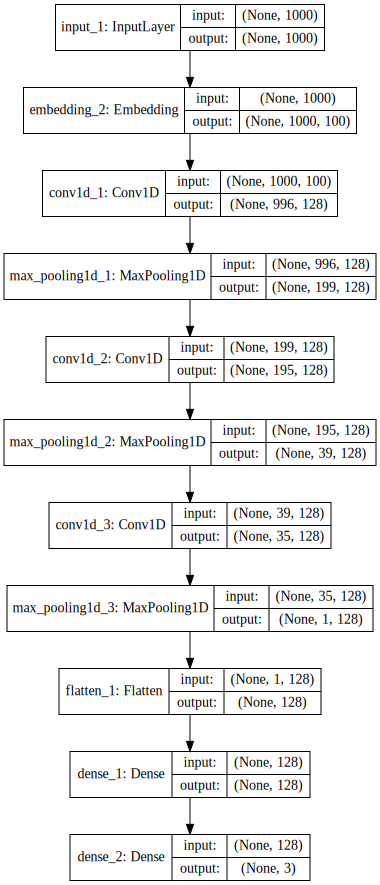

In [41]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### CNN 모델 생성 및 학습 (한국어/실습)

In [42]:
# -- coding

## 학습된 모델로 새로운 문장(or 문서) 분류하기 (영어 - 20newsgroups)

In [43]:
def process_text(text):
    """ 
    Process the input text by tokenizing and padding it.
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text)
    x = tokenizer.texts_to_sequences(text)

    x = pad_sequences(x, maxlen=MAX_SEQUENCE_LENGTH)
    return x

In [44]:
input_text = 'artificial intelligence'

matrix = process_text(input_text)

predictions = model.predict(matrix)

categories=['alt.atheism', 'comp.graphics', 'sci.space']
# get the actual categories from output
scoredict = {}
for idx, classlabel in zip(range(len(categories)), categories):
    scoredict[classlabel] = predictions[0][idx]

print(scoredict)

{'comp.graphics': 0.50177741, 'alt.atheism': 0.057258479, 'sci.space': 0.4409641}


## 학습된 모델로 새로운 문장(or 문서) 분류하기 (한국어/실습)

In [45]:
# -- coding

---------------------------------------

# 2D CNN for Text (Gensim + Keras)

#### 참고
* [3] https://github.com/bhaveshoswal/CNN-text-classification-keras

<img src="http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/11/Screen-Shot-2015-11-06-at-8.03.47-AM.png" width=600 />

In [46]:
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model

In [47]:
sequence_length = MAX_SEQUENCE_LENGTH
vocabulary_size = len(Keras_w2v_wv.vocab.items())
embedding_dim = 256
filter_sizes = [3,4,5]
num_filters = 512
drop = 0.5

epochs = 100
batch_size = 30

# this returns a tensor
print("Creating Model...")
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
print("Traning Model...")
model.fit(x_train, y_train, epochs=5) # batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=(X_test, y_test))  # starts training


Creating Model...
Traning Model...
Epoch 1/5
137/137 [==============================] - 45s 332ms/step - loss: 0.6447 - acc: 0.6667
Epoch 2/5
137/137 [==============================] - 51s 376ms/step - loss: 0.6146 - acc: 0.6667
Epoch 3/5
137/137 [==============================] - 41s 297ms/step - loss: 0.5868 - acc: 0.6667

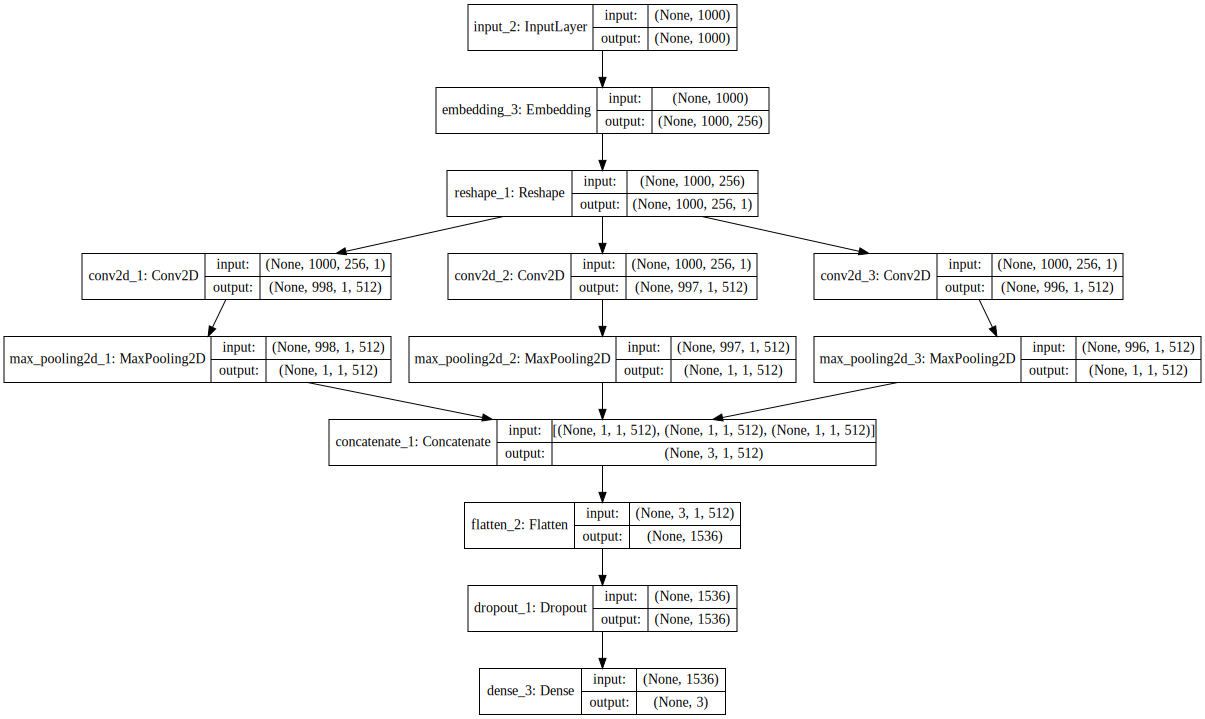

In [48]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [49]:
input_text = 'artificial intelligence'

matrix = process_text(input_text)

predictions = model.predict(matrix)

categories=['alt.atheism', 'comp.graphics', 'sci.space']
# get the actual categories from output
scoredict = {}
for idx, classlabel in zip(range(len(categories)), categories):
    scoredict[classlabel] = predictions[0][idx]

print(scoredict)

{'comp.graphics': 0.42833376, 'alt.atheism': 0.15063439, 'sci.space': 0.42103183}


# 참고자료
* [2] Using wrappers for Gensim models for working with Keras - https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/keras_wrapper.ipynb
* [3] https://github.com/bhaveshoswal/CNN-text-classification-keras
* [4] https://github.com/keras-team/keras/blob/ce406b773b9f36be5718a4369ad07fea4f9ebdba/examples/imdb_cnn.py